# Title: Anomaly Detection in Network Traffic using AI/ML (NSL-KDD)
## Dataset: NSL-KDD (Train/Test CSV from Hugging Face)
## Team Name: Synergy

### STEP 01 : Importing all required Python libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')

# For better plot aesthetics
sns.set(style="whitegrid")


### STEP 2: Load the NSL-KDD Dataset

In [2]:
print(" Loading NSL-KDD dataset...")

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Combine train and test sets
df = pd.concat([df_train, df_test], ignore_index=True)

print(" Dataset Loaded Successfully!")
print("Shape:", df.shape)
df.head()


 Loading NSL-KDD dataset...
 Dataset Loaded Successfully!
Shape: (185559, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


### STEP 3: Simplify Labels (Normal vs Attack)

In [6]:
# Convert multi-class labels into binary classes
df['label'] = df['label'].apply(lambda x: 'normal' if x.strip().lower() == 'normal' else 'attack')

print("Labels simplified into 'normal' and 'attack'.")
df['label'].value_counts()


Labels simplified into 'normal' and 'attack'.


label
attack    92904
normal    92655
Name: count, dtype: int64

### STEP 4: Encode Categorical Columns

In [7]:
# Encode categorical features
categorical_cols = ['protocol_type', 'service', 'flag']
encoder = LabelEncoder()

for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

print("Categorical columns encoded successfully!")


Categorical columns encoded successfully!


### STEP 5: Split Data and Apply Feature Scaling

In [8]:
X = df.drop(['label'], axis=1)
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

print("Data split into training and testing sets.")
print("Training Samples:", X_train.shape[0])
print("Testing Samples:", X_test.shape[0])


Data split into training and testing sets.
Training Samples: 129891
Testing Samples: 55668


### STEP 6: Supervised Learning Models (RF, SVM, KNN)


⚙ Training Random Forest...

===== Random Forest Results =====
Accuracy: 99.7 %
              precision    recall  f1-score   support

      attack       1.00      1.00      1.00     27871
      normal       1.00      1.00      1.00     27797

    accuracy                           1.00     55668
   macro avg       1.00      1.00      1.00     55668
weighted avg       1.00      1.00      1.00     55668



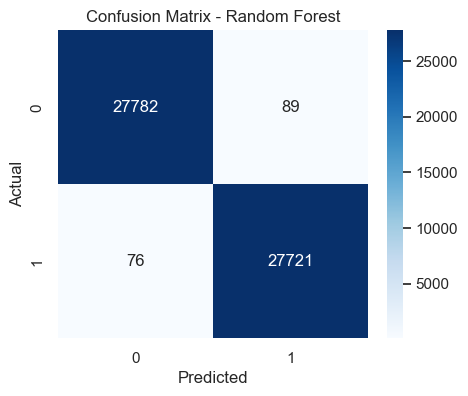


⚙ Training SVM...

===== SVM Results =====
Accuracy: 98.01 %
              precision    recall  f1-score   support

      attack       0.98      0.98      0.98     27871
      normal       0.98      0.98      0.98     27797

    accuracy                           0.98     55668
   macro avg       0.98      0.98      0.98     55668
weighted avg       0.98      0.98      0.98     55668



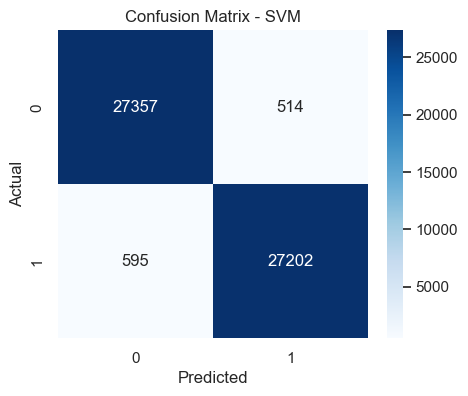


⚙ Training KNN...

===== KNN Results =====
Accuracy: 99.07 %
              precision    recall  f1-score   support

      attack       0.99      0.99      0.99     27871
      normal       0.99      0.99      0.99     27797

    accuracy                           0.99     55668
   macro avg       0.99      0.99      0.99     55668
weighted avg       0.99      0.99      0.99     55668



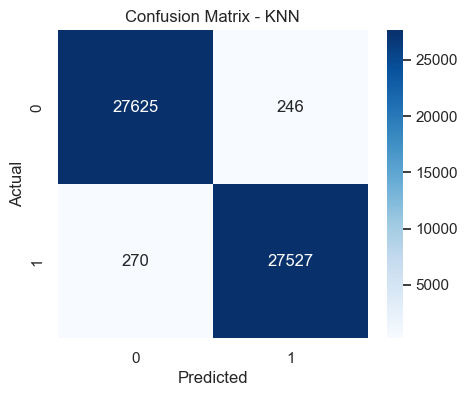

In [9]:
models_list = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = []

for name, model in models_list.items():
    print(f"\n Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))

    print(f"\n===== {name} Results =====")
    print("Accuracy:", round(acc * 100, 2), "%")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


### STEP 7: Compare Supervised Model Performance

In [10]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=False)
print("\n Model Comparison:")
display(results_df)



 Model Comparison:


,Model,Accuracy
0,Random Forest,0.997036
2,KNN,0.990731
1,SVM,0.980078


### STEP 8: Unsupervised Learning — Isolation Forest

In [11]:
print("\n Running Isolation Forest...")

iso_forest = IsolationForest(contamination=0.2, random_state=42)
iso_pred = iso_forest.fit_predict(X_scaled)
iso_pred = np.where(iso_pred == -1, 'attack', 'normal')

print("\n===== Isolation Forest Results =====")
print(classification_report(y, iso_pred))



 Running Isolation Forest...

===== Isolation Forest Results =====
              precision    recall  f1-score   support

      attack       0.75      0.30      0.43     92904
      normal       0.56      0.90      0.69     92655

    accuracy                           0.60    185559
   macro avg       0.65      0.60      0.56    185559
weighted avg       0.65      0.60      0.56    185559



### STEP 9: Deep Learning — Autoencoder for Anomaly Detection

In [12]:
print("\n Training Deep Learning Autoencoder...")

input_dim = X_scaled.shape[1]

autoencoder = models.Sequential([
    layers.Dense(64, activation='relu', input_dim=input_dim),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')

# Train only on normal samples
X_normal = X_scaled[y == 'normal']
history = autoencoder.fit(
    X_normal, X_normal,
    epochs=10, batch_size=64, validation_split=0.1, verbose=0
)

# Reconstruction error threshold
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)

y_pred_ae = np.where(mse > threshold, 'attack', 'normal')

print("\n===== Autoencoder Results =====")
print(classification_report(y, y_pred_ae))



 Training Deep Learning Autoencoder...
5799/5799 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

===== Autoencoder Results =====
              precision    recall  f1-score   support

      attack       0.76      0.08      0.14     92904
      normal       0.51      0.98      0.67     92655

    accuracy                           0.53    185559
   macro avg       0.64      0.53      0.40    185559
weighted avg       0.64      0.53      0.40    185559



### STEP 10: Feature Importance (Random Forest)

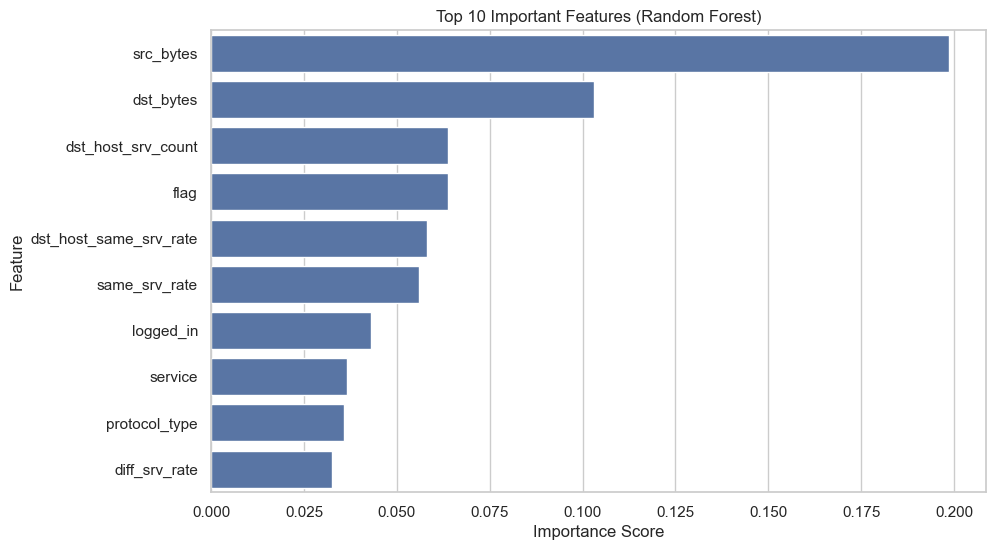

In [13]:
rf_model = models_list["Random Forest"]
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


### STEP 11: PCA Visualization (2D)

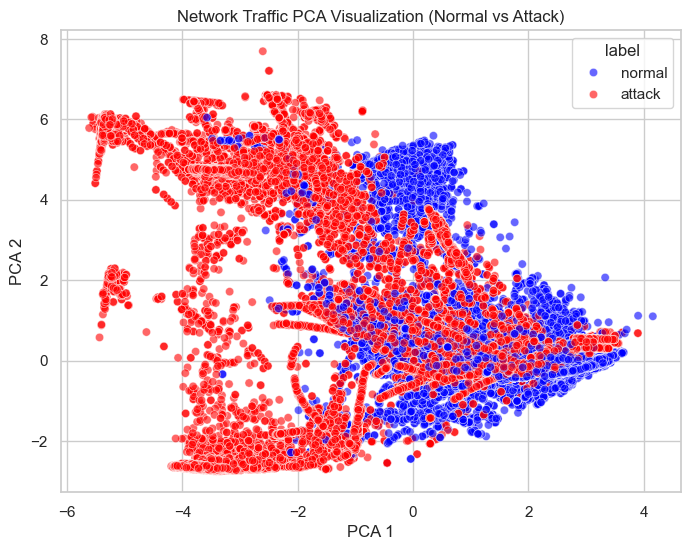

In [14]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['label'],
                palette={'normal': 'blue', 'attack': 'red'}, alpha=0.6)
plt.title("Network Traffic PCA Visualization (Normal vs Attack)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


### Step 12: ROC Curve (Random Forest)

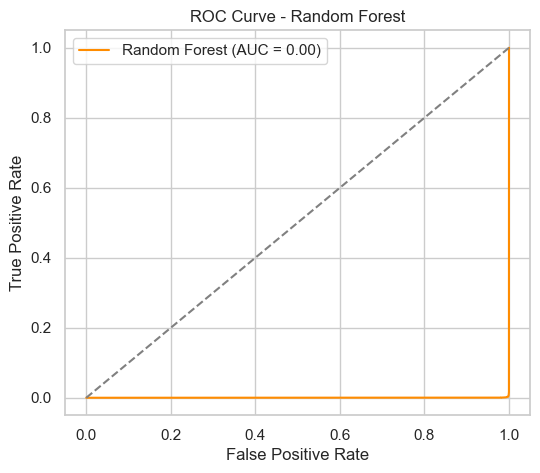

In [15]:
y_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test.map({'normal': 0, 'attack': 1}), y_prob)
roc_auc = roc_auc_score(y_test.map({'normal': 0, 'attack': 1}), y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()


### STEP 13: Summary

In [16]:
print("Project Summary")
print("===========================")
print(results_df)
print("\n Isolation Forest (Unsupervised) and Autoencoder (Deep Learning) evaluated successfully.")
print("\n Project Completed Successfully using NSL-KDD Dataset!")


Project Summary
           Model  Accuracy
0  Random Forest  0.997036
2            KNN  0.990731
1            SVM  0.980078

 Isolation Forest (Unsupervised) and Autoencoder (Deep Learning) evaluated successfully.

 Project Completed Successfully using NSL-KDD Dataset!
